# Question revision chain

- get a question
- LLM A and B verify if the question is OK
    - there is more than one option correct
    - sugest a detailed explanation to each option
- verify if correct_answer is equal for both
    - if YES: 
        - verify if there is just one option true:
            - if YES: 
                - there is nothing to do with this question because the LLMs didnt found any problem
                - just take the explanations from gemini and set the correct answer and save
                
            - if NO: 
                - take a vote from openai
                - go to the part of save the question because it should have a majority vote for one option
    - if NO: 
        - if it is not passing this part for the second time
            - if YES:
                - fix the options
                - go to the start of flow
            - if NO: 
                - discart this question because it already tried to fix it

In [74]:
from dotenv import load_dotenv
import json_repair
import json
import os
import pandas as pd

from pydantic import BaseModel, Field
from typing import Literal

from langgraph.graph import END, START, StateGraph, MessagesState
from typing_extensions import TypedDict
# from typing import Annotated
from IPython.display import Image, display


from supabase import create_client, Client

import os
from dotenv import load_dotenv
load_dotenv()  # take environment variables from .env.

True

In [66]:
url: str = os.environ.get("SUPABASE_URL")
key: str = os.environ.get("SUPABASE_KEY")
supabase: Client = create_client(url, key)

In [2]:
df = pd.read_csv("questions.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 953 non-null    int64 
 1   created_at         953 non-null    object
 2   subject_matter     953 non-null    object
 3   topic_description  953 non-null    object
 4   level              953 non-null    object
 5   question           953 non-null    object
 6   type               953 non-null    object
 7   answer_correct     953 non-null    object
 8   explanation        953 non-null    object
 9   answer_a           953 non-null    object
 10  answer_b           953 non-null    object
 11  answer_c           953 non-null    object
 12  answer_d           953 non-null    object
dtypes: int64(1), object(12)
memory usage: 96.9+ KB


In [3]:
question = df.iloc[0]
question

id                                                                  11
created_at                               2024-09-22 12:31:43.546285+00
subject_matter                                             Probability
topic_description                       Understanding Confusion Matrix
level                                                     1 - Remember
question             Which term represents correctly classified pos...
type                                                  multiple_options
answer_correct                                                       a
explanation          True Positives (TP) represent the number of ca...
answer_a                                                True Positives
answer_b                                               False Positives
answer_c                                               False Negatives
answer_d                                                True Negatives
Name: 0, dtype: object

In [4]:
question["question"]

'Which term represents correctly classified positive cases?'

## Gemini

In [5]:
import google.generativeai as genai
from google.ai.generativelanguage_v1beta.types import content

key_gemini = os.environ["GOOGLE_API_KEY"]

genai.configure(api_key=key_gemini)

/workspaces/quiz_interview/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
schema = content.Schema(
    type=content.Type.OBJECT,
    properties={
        "option_a_explanation": content.Schema(
            type=content.Type.STRING,
            description="Detailed explanation of why the option 'a' is correct or not.",
        ),
        "option_b_explanation": content.Schema(
            type=content.Type.STRING,
            description="Detailed explanation of why the option 'b' is correct or not.",
        ),
        "option_c_explanation": content.Schema(
            type=content.Type.STRING,
            description="Detailed explanation of why the option 'c' is correct or not.",
        ),
        "option_d_explanation": content.Schema(
            type=content.Type.STRING,
            description="Detailed explanation of why the option 'd' is correct or not.",
        ),
        "just_one_option_correct": content.Schema(
            type=content.Type.BOOLEAN,
            description="If there is just one option correct.",
        ),
        "correct_answer": content.Schema(
            type=content.Type.STRING,
            description="The correct option. It could be 'a', 'b', 'c', 'd'.",
        ),
    },
    required=[
        "option_a_explanation",
        "option_b_explanation",
        "option_c_explanation",
        "option_d_explanation",
        "just_one_option_correct",
        "correct_answer",
    ]
)

In [7]:
# Create the model
generation_config = {
    "temperature": 0.5,
    "top_p": 0.95,
    # "top_k": 64,
    # "max_output_tokens": 8192,
    "response_schema": schema,
    "response_mime_type": "application/json",
}
    

llm_gemini = genai.GenerativeModel(
    # model_name="gemini-1.5-flash",
    model_name="gemini-1.5-flash-exp-0827",
    # model_name="gemini-1.5-pro-exp-0827",
    generation_config=generation_config,
    # safety_settings = Adjust safety settings
    # See https://ai.google.dev/gemini-api/docs/safety-settings
)

In [21]:
prompt_revision = (
    "# BACKGROUND INFORMATION OF YOUR ROLE:\n"
    "You are an expert in machine learning.\n"
    "You are verifying if a question from a bank of question is ok to be used in a job interview.\n"
    "your task is to analyse the provided question to verify if there is some problem.\n"
    "You shoud verify if there is just one option correct or if there is more than one.\n"
    "The question could be perfect fine, so you could say it too.\n"
    "Also, you should give a detailed explanation for your answer.\n"
    "# QUESTION\n\n"
    "{question}\n\n"
    "# Option a\n"
    "{option_a}\n\n"
    "# Option b\n"
    "{option_b}\n\n"
    "# Option c\n"
    "{option_c}\n\n"
    "# Option d\n"
    "{option_d}\n\n"
)

In [10]:
prompt_revision_formatted = prompt_revision.format(
        question=question["question"],
        option_a=question["answer_a"],
        option_b=question["answer_b"],
        option_c=question["answer_c"],
        option_d=question["answer_d"],        
    )

print( prompt_revision_formatted )

# BACKGROUND INFORMATION OF YOUR ROLE:
You are an expert in machine learning.
You are verifying if a question from a bank of question is ok to be used in a job interview.
your task is to analyse the provided question to verify if there is some problem.
You shoud verify if there is just one option correct or if there is more than one.
The question could be perfect fine, so you could say it too.
Also, you should give a detailed explanation for your answer.
# QUESTION

Which term represents correctly classified positive cases?

# Option a
True Positives

# Option b
False Positives

# Option c
False Negatives

# Option d
True Negatives




In [11]:
response = llm_gemini.generate_content(prompt_revision_formatted)
response

response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "{\"correct_answer\": \"a\", \"just_one_option_correct\": true, \"option_a_explanation\": \"True Positives (TP) represent the cases where the model correctly predicts a positive outcome when the actual outcome is also positive. It is a measure of how well the model identifies positive cases.\", \"option_b_explanation\": \"False Positives (FP) represent the cases where the model incorrectly predicts a positive outcome when the actual outcome is negative. It is a measure of how often the model incorrectly identifies a positive case.\", \"option_c_explanation\": \"False Negatives (FN) represent the cases where the model incorrectly predicts a negative outcome when the actual outcome is positive. It is a measure of how often the model fails to identify a positive

In [12]:
gemini_analysis = json_repair.loads(response.text)
gemini_analysis

{'correct_answer': 'a',
 'just_one_option_correct': True,
 'option_a_explanation': 'True Positives (TP) represent the cases where the model correctly predicts a positive outcome when the actual outcome is also positive. It is a measure of how well the model identifies positive cases.',
 'option_b_explanation': 'False Positives (FP) represent the cases where the model incorrectly predicts a positive outcome when the actual outcome is negative. It is a measure of how often the model incorrectly identifies a positive case.',
 'option_c_explanation': 'False Negatives (FN) represent the cases where the model incorrectly predicts a negative outcome when the actual outcome is positive. It is a measure of how often the model fails to identify a positive case.',
 'option_d_explanation': 'True Negatives (TN) represent the cases where the model correctly predicts a negative outcome when the actual outcome is also negative. It is a measure of how well the model identifies negative cases.'}

## Llama 3.1

In [17]:
class ExplanationSchema(BaseModel):
    option_a_explanation: str = Field(..., description="Detailed explanation of why the option 'a' is correct or not.")
    option_b_explanation: str = Field(..., description="Detailed explanation of why the option 'b' is correct or not.")
    option_c_explanation: str = Field(..., description="Detailed explanation of why the option 'c' is correct or not.")
    option_d_explanation: str = Field(..., description="Detailed explanation of why the option 'd' is correct or not.")
    just_one_option_correct: bool = Field(..., description="If there is just one option correct.")
    correct_answer: Literal['a', 'b', 'c', 'd'] = Field(..., description="The correct option. It could be 'a', 'b', 'c', or 'd'.")


In [14]:
from groq import Groq

key_groq = os.environ["GROQ_API_KEY"]
client = Groq(api_key=key_groq)

In [15]:
prompt_revision_with_json = prompt_revision + (
    "# OUTPUT FORMAT: json\n\n"
    "{output_format}"
)

In [16]:
prompt_revision_formatted = prompt_revision_with_json.format(
        question=question["question"],
        option_a=question["answer_a"],
        option_b=question["answer_b"],
        option_c=question["answer_c"],
        option_d=question["answer_d"],
        output_format=json.dumps(ExplanationSchema.model_json_schema(), indent=2)
    )

print( prompt_revision_formatted )

# BACKGROUND INFORMATION OF YOUR ROLE:
You are an expert in machine learning.
You are verifying if a question from a bank of question is ok to be used in a job interview.
your task is to analyse the provided question to verify if there is some problem.
You shoud verify if there is just one option correct or if there is more than one.
The question could be perfect fine, so you could say it too.
Also, you should give a detailed explanation for your answer.
# QUESTION

Which term represents correctly classified positive cases?

# Option a
True Positives

# Option b
False Positives

# Option c
False Negatives

# Option d
True Negatives

# OUTPUT FORMAT: json

{
  "properties": {
    "option_a_explanation": {
      "description": "Detailed explanation of why the option 'a' is correct or not.",
      "title": "Option A Explanation",
      "type": "string"
    },
    "option_b_explanation": {
      "description": "Detailed explanation of why the option 'b' is correct or not.",
      "title": 

In [17]:
response = client.chat.completions.create(
    # model="llama3-8b-8192",
    model="llama-3.1-70b-versatile",
    messages=[{
        "role": "user",
        "content": prompt_revision_formatted
    }],
    temperature=0.5,
    # max_tokens=2420,
    top_p=0.95,
    stream=False,
    response_format={"type": "json_object"},
    stop=None,
)

completion = response.choices[0].message
llama_analysis = json_repair.loads(completion.content)
llama_analysis

{'option_a_explanation': 'This option is correct because True Positives represent the cases that are correctly classified as positive. In the context of machine learning, this term is used to describe the number of instances that are correctly predicted as belonging to the positive class.',
 'option_b_explanation': 'This option is incorrect because False Positives represent the cases that are incorrectly classified as positive. In other words, these are the instances that do not belong to the positive class but are predicted as such.',
 'option_c_explanation': 'This option is incorrect because False Negatives represent the cases that are incorrectly classified as negative. In other words, these are the instances that belong to the positive class but are predicted as not belonging to it.',
 'option_d_explanation': 'This option is incorrect because True Negatives represent the cases that are correctly classified as negative. In other words, these are the instances that do not belong to t

## OpenAI

In [5]:
from openai import OpenAI

client = OpenAI()

In [ ]:
# prompt_merge = (
#     "# BACKGROUND INFORMATION OF YOUR ROLE:\n"
#     "You are an expert in machine learning.\n"
#     "You working (with some other professionals) verifying if a question from a bank of question is ok to be used in a job interview.\n"
#     "The question has already been analized by other professionals. Their analysis is below.\n"
#     "# YOUR TASK\n"
#     "your task is to give a detailed explanation for each option taken in consideration the analysis from the experts.\n"
#     "You should also take in consideration the choosen"
# )

## Avaliate question

In [22]:
prompt_revision_formatted = prompt_revision.format(
        question=question["question"],
        option_a=question["answer_a"],
        option_b=question["answer_b"],
        option_c=question["answer_c"],
        option_d=question["answer_d"],
        # output_format=json.dumps(ExplanationSchema.model_json_schema(), indent=2)
    )

print( prompt_revision_formatted )

# BACKGROUND INFORMATION OF YOUR ROLE:
You are an expert in machine learning.
You are verifying if a question from a bank of question is ok to be used in a job interview.
your task is to analyse the provided question to verify if there is some problem.
You shoud verify if there is just one option correct or if there is more than one.
The question could be perfect fine, so you could say it too.
Also, you should give a detailed explanation for your answer.
# QUESTION

Which term represents correctly classified positive cases?

# Option a
True Positives

# Option b
False Positives

# Option c
False Negatives

# Option d
True Negatives




In [23]:
completion = client.beta.chat.completions.parse(
    model="gpt-4o-mini",
    messages=[
        {"role": "system", "content": prompt_revision_formatted},
        # {"role": "user", "content": "hello"}
    ],
    response_format=ExplanationSchema,
)

In [24]:
completion.choices[0].message.parsed

ExplanationSchema(option_a_explanation='True Positives (TP) are the results that indicate the presence of a condition (positive cases) correctly identified by a classification model. In binary classification, when we say a case is a true positive, it means that the model has correctly predicted the positive class, thus, this is the correct definition for correctly classified positive cases.', option_b_explanation='False Positives (FP) refer to the instances where the model predicts the positive class incorrectly; that is, the model predicted a positive when the actual case was negative. This does not represent correctly classified positive cases, hence this option is incorrect.', option_c_explanation='False Negatives (FN) are instances where the model fails to identify a positive case and predicts it as negative. This results in missing a positive case, and thus, is the opposite of correctly classified positive cases. Therefore, this option is also incorrect.', option_d_explanation='Tr

In [39]:
type(completion.choices[0].message.parsed)

__main__.ExplanationSchema

In [40]:
completion.choices[0].message.parsed.option_a_explanation

'True Positives (TP) are the results that indicate the presence of a condition (positive cases) correctly identified by a classification model. In binary classification, when we say a case is a true positive, it means that the model has correctly predicted the positive class, thus, this is the correct definition for correctly classified positive cases.'

In [51]:
analysis_openai = json_repair.loads( completion.choices[0].message.parsed.model_dump_json() )
analysis_openai

{'option_a_explanation': 'True Positives (TP) are the results that indicate the presence of a condition (positive cases) correctly identified by a classification model. In binary classification, when we say a case is a true positive, it means that the model has correctly predicted the positive class, thus, this is the correct definition for correctly classified positive cases.',
 'option_b_explanation': 'False Positives (FP) refer to the instances where the model predicts the positive class incorrectly; that is, the model predicted a positive when the actual case was negative. This does not represent correctly classified positive cases, hence this option is incorrect.',
 'option_c_explanation': 'False Negatives (FN) are instances where the model fails to identify a positive case and predicts it as negative. This results in missing a positive case, and thus, is the opposite of correctly classified positive cases. Therefore, this option is also incorrect.',
 'option_d_explanation': 'True

In [52]:
analysis_openai

{'option_a_explanation': 'True Positives (TP) are the results that indicate the presence of a condition (positive cases) correctly identified by a classification model. In binary classification, when we say a case is a true positive, it means that the model has correctly predicted the positive class, thus, this is the correct definition for correctly classified positive cases.',
 'option_b_explanation': 'False Positives (FP) refer to the instances where the model predicts the positive class incorrectly; that is, the model predicted a positive when the actual case was negative. This does not represent correctly classified positive cases, hence this option is incorrect.',
 'option_c_explanation': 'False Negatives (FN) are instances where the model fails to identify a positive case and predicts it as negative. This results in missing a positive case, and thus, is the opposite of correctly classified positive cases. Therefore, this option is also incorrect.',
 'option_d_explanation': 'True

### Try to fix question

In [45]:
prompt_fix_question = (
    "# BACKGROUND INFORMATION OF YOUR ROLE:\n"
    "You are an expert in machine learning.\n"
    "You working (with some other professionals) verifying if a question from a bank of question is ok to be used in a job interview.\n"
    "The question has already been analized by other professionals. Their analysis is below.\n"
    "It was already pointed that this question could have more than one option as correct, but it shouldn't. It should have just one correct option.\n"
    "# YOUR TASK\n"
    "your task is to fix the questions and/or the options in a way that it mantain the overall ideia for this question, but it should have after your correction, just one option as correct.\n"
    "Also, you should give a detailed explanation for your answer.\n\n"
    "# ORIGINAL QUESTION\n\n"
    "{question}\n\n"
    "# Option a\n"
    "{option_a}\n\n"
    "# Option b\n"
    "{option_b}\n\n"
    "# Option c\n"
    "{option_c}\n\n"
    "# Option d\n"
    "{option_d}\n\n"

    "# PROFESSIONAL ONE ANALYSIS\n"
    "option_a_explanation\n"
    "{option_a_explanation}\n"
    "option_b_explanation\n"
    "{option_b_explanation}\n"
    "option_c_explanation\n"
    "{option_c_explanation}\n"
    "option_d_explanation\n"
    "{option_d_explanation}\n"
    
)

In [53]:
prompt_fix_question_formatted = prompt_fix_question.format(
        question=question["question"],
        option_a=question["answer_a"],
        option_b=question["answer_b"],
        option_c=question["answer_c"],
        option_d=question["answer_d"],
        
        option_a_explanation=analysis_openai["option_a_explanation"],
        option_b_explanation=analysis_openai["option_b_explanation"],
        option_c_explanation=analysis_openai["option_c_explanation"],
        option_d_explanation=analysis_openai["option_d_explanation"],
    )

print( prompt_fix_question_formatted )

# BACKGROUND INFORMATION OF YOUR ROLE:
You are an expert in machine learning.
You working (with some other professionals) verifying if a question from a bank of question is ok to be used in a job interview.
The question has already been analized by other professionals. Their analysis is below.
It was already pointed that this question could have more than one option as correct, but it shouldn't. It should have just one correct option.
# YOUR TASK
your task is to fix the questions and/or the options in a way that it mantain the overall ideia for this question, but it should have after your correction, just one option as correct.
Also, you should give a detailed explanation for your answer.

# ORIGINAL QUESTION

Which term represents correctly classified positive cases?

# Option a
True Positives

# Option b
False Positives

# Option c
False Negatives

# Option d
True Negatives

# PROFESSIONAL ONE ANALYSIS
option_a_explanation
True Positives (TP) are the results that indicate the presenc

In [18]:
completion = client.beta.chat.completions.parse(
    model="gpt-4o-mini",
    messages=[
        {"role": "system", "content": prompt_fix_question_formatted},
        # {"role": "user", "content": "hello"}
    ],
    response_format=ExplanationSchema,
)

In [19]:
completion.choices[0].message.parsed

ExplanationSchema(option_a_explanation="Option a, 'True Positives', is correct because it specifically refers to the cases in which the positive instances are correctly identified by the model. In terms of classification outcomes, true positives are those instances that are actual positives, and the model has correctly classified them as positive.", option_b_explanation="Option b, 'False Positives', is incorrect because it refers to the cases where the model incorrectly classifies negative instances as positive. This does not represent correctly classified positive cases.", option_c_explanation="Option c, 'False Negatives', is also incorrect as it represents the cases where actual positive instances are incorrectly classified as negative. This means that the positive cases are not correctly identified by the model, which is the opposite of what the question requires.", option_d_explanation="Option d, 'True Negatives', is incorrect because it refers to the instances that are correctly c

# Graph

In [70]:
class State(TypedDict):
    question_start: dict
    analysis_gemini: dict
    analysis_llama: dict
    analysis_openai: dict
    question_openai_fixed: dict
    already_tried_to_fix: bool = False

In [36]:
def chain_analysis_gemini(state: State):
    already_tried_to_fix = state["already_tried_to_fix"]

    if already_tried_to_fix:
        question = state["question_openai_fixed"]
    else:
        question = state["question_start"]


    prompt_revision_formatted = prompt_revision.format(
        question=question["question"],
        option_a=question["answer_a"],
        option_b=question["answer_b"],
        option_c=question["answer_c"],
        option_d=question["answer_d"],        
    )

    response = llm_gemini.generate_content(prompt_revision_formatted)
    analysis_gemini = json_repair.loads(response.text)
    
    return { "analysis_gemini": analysis_gemini }


In [37]:
def chain_analysis_llama(state: State):
    already_tried_to_fix = state["already_tried_to_fix"]

    if already_tried_to_fix:
        question = state["question_openai_fixed"]
    else:
        question = state["question_start"]

    prompt_revision_with_json = prompt_revision + (
        "# OUTPUT FORMAT: json\n\n"
        "{output_format}"
    )

    prompt_revision_formatted = prompt_revision_with_json.format(
        question=question["question"],
        option_a=question["answer_a"],
        option_b=question["answer_b"],
        option_c=question["answer_c"],
        option_d=question["answer_d"],
        output_format=json.dumps(ExplanationSchema.model_json_schema(), indent=2)
    )

    response = client.chat.completions.create(
        # model="llama3-8b-8192",
        model="llama-3.1-70b-versatile",
        messages=[{
            "role": "user",
            "content": prompt_revision_formatted
        }],
        temperature=0.5,
        # max_tokens=2420,
        top_p=0.95,
        stream=False,
        response_format={"type": "json_object"},
        stop=None,
    )

    completion = response.choices[0].message
    analysis_llama = json_repair.loads(completion.content)
    
    return { "analysis_llama": analysis_llama }

In [56]:
def chain_analysis_openai(state: State):
    question = state["question_start"]

    prompt_revision_formatted = prompt_revision.format(
        question=question["question"],
        option_a=question["answer_a"],
        option_b=question["answer_b"],
        option_c=question["answer_c"],
        option_d=question["answer_d"],
    )
    
    completion = client.beta.chat.completions.parse(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": prompt_revision_formatted},
            # {"role": "user", "content": "hello"}
        ],
        response_format=ExplanationSchema,
    )

    analysis_openai = json_repair.loads( completion.choices[0].message.parsed.model_dump_json() )

    return { "analysis_openai": analysis_openai }

In [55]:
def chain_try_fix_question(state: State):
    question = state["question_start"]

    prompt_fix_question_formatted = prompt_fix_question.format(
        question=question["question"],
        option_a=question["answer_a"],
        option_b=question["answer_b"],
        option_c=question["answer_c"],
        option_d=question["answer_d"],

        option_a_explanation=analysis_openai["option_a_explanation"],
        option_b_explanation=analysis_openai["option_b_explanation"],
        option_c_explanation=analysis_openai["option_c_explanation"],
        option_d_explanation=analysis_openai["option_d_explanation"],
    )

    completion = client.beta.chat.completions.parse(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": prompt_fix_question_formatted},
            # {"role": "user", "content": "hello"}
        ],
        response_format=ExplanationSchema,
    )

    question_openai_fixed = json_repair.loads(
        completion.choices[0].message.parsed.model_dump_json()
    )

    return {
        "question_openai_fixed": question_openai_fixed,
        "already_tried_to_fix": True
    }

In [72]:
def save_question(state: State):
    question_start = state["question_start"]
    analysis_gemini = state["analysis_gemini"]
    analysis_llama = state["analysis_llama"]
    analysis_openai = state["analysis_openai"]

    if analysis_openai:
        if analysis_openai["correct_answer"] == analysis_gemini["correct_answer"]:
            question = analysis_openai
        elif analysis_openai["correct_answer"] == analysis_llama["correct_answer"]:
            question = analysis_openai
        elif analysis_gemini["correct_answer"] == analysis_llama["correct_answer"]:
            question = analysis_gemini
        else:
            # if any of the LLMs agree, dont save this question
            return END
    else:
        question = analysis_gemini
    
    response = supabase.table('question').insert(
        {
            "subject_matter": question_start["subject_matter"],
            "topic_description": question_start["topic_description"],
            "level": question_start["level"],
            "question": question_start["question"],
            "type": question_start["type"],
            "answer_correct": question["answer_correct"],
            "answer_a": question_start["answer_a"],
            "answer_b": question_start["answer_b"],
            "answer_c": question_start["answer_c"],
            "answer_d": question_start["answer_d"],
            "explanation_a": question["explanation_a"],
            "explanation_b": question["explanation_b"],
            "explanation_c": question["explanation_c"],
            "explanation_d": question["explanation_d"],
        }).execute()

In [69]:
def verify_correct_answer_is_equal(state: State):
    analysis_gemini = state["analysis_gemini"]
    analysis_llama = state["analysis_llama"]
    already_tried_to_fix = state["already_tried_to_fix"]

    if analysis_gemini["correct_answer"] == analysis_llama['correct_answer']:
        if analysis_gemini["just_one_option_correct"] and analysis_llama['just_one_option_correct']:
            return "save_question"
        else:
            return "chain_analysis_openai"
    elif already_tried_to_fix:
        return END
    else:
        # i could try open ai analysis before try to fix
        return "chain_try_fix_question"


# def verify_correct_answer_is_equal(state: State):
#     analysis_gemini = state["analysis_gemini"]
#     analysis_llama = state["analysis_llama"]
#     already_tried_to_fix = state["already_tried_to_fix"]

#     if analysis_gemini["correct_answer"] == analysis_llama['correct_answer']:
#         if analysis_gemini["just_one_option_correct"] and analysis_llama['just_one_option_correct']:
#             return "save_question"
#         else:
#             return "chain_analysis_openai"
#     elif already_tried_to_fix:
#         return END
#     else:
#         return "chain_try_fix_question"

In [71]:
graph_builder = StateGraph(State)

graph_builder.add_node("chain_analysis_gemini", chain_analysis_gemini)
graph_builder.add_node("chain_analysis_llama", chain_analysis_llama)
graph_builder.add_node("chain_analysis_openai", chain_analysis_openai)
graph_builder.add_node("chain_try_fix_question", chain_try_fix_question)
graph_builder.add_node("save_question", save_question)

graph_builder.add_edge(START, "chain_analysis_gemini")
graph_builder.add_edge("chain_analysis_gemini", "chain_analysis_llama")
graph_builder.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "chain_analysis_llama",
    # Next, we pass in the function that will determine which node is called next.
    verify_correct_answer_is_equal,
)

graph_builder.add_edge("chain_analysis_openai", "save_question")
graph_builder.add_edge("chain_try_fix_question", "chain_analysis_gemini")
graph_builder.add_edge("save_question", END)

In [73]:
app = graph_builder.compile()

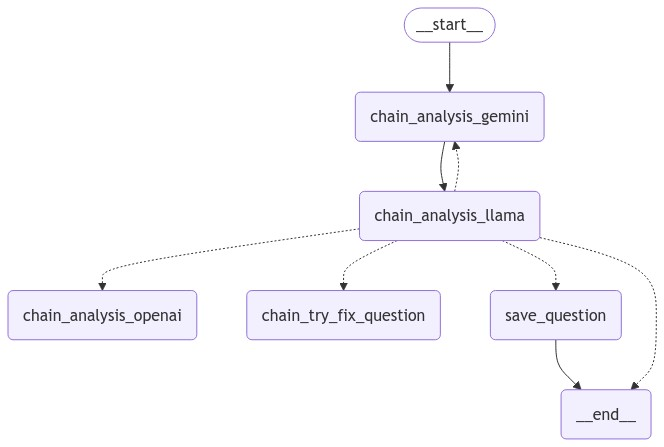

In [76]:
display(Image(app.get_graph().draw_mermaid_png()))